In [27]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.cluster.hierarchy import dendrogram, linkage

## Problem 1.2.4: Limiting PageRank values

## b)

In [29]:
# Define the graph, using alphabet-order node enumeration
A = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 0]
])

# compute P
D_out = np.diag(
    [2, 2, 2, 1, 2, 2]
)

P = np.linalg.inv(D_out) @ A

In [30]:
# pi is the e-vector of P.T with e-val 1
# find e-vals w and e-vectors v
w, v = np.linalg.eig(P.T)
w

array([ 1.00000000e+00+0.j        , -3.40275770e-01+0.81658512j,
       -3.40275770e-01-0.81658512j,  9.11172734e-09+0.j        ,
       -9.11172727e-09+0.j        , -3.19448460e-01+0.j        ])

In [31]:
# w_1 = 1, so get the first eigenvector
pi = np.real(v[:, 0])

# normalize to sum to 1
pi /= pi.sum()
pi


array([0.15384615, 0.15384615, 0.07692308, 0.23076923, 0.07692308,
       0.30769231])

## d)

pi:
[[0.15384615]
 [0.15384615]
 [0.07692308]
 [0.23076923]
 [0.07692308]
 [0.30769231]]


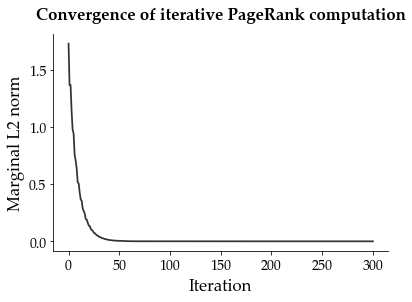

In [32]:
# solve for pi iteratively 

# let x = ones vector
x = np.ones((A.shape[0], 1))

# track convergence
norms = []
prev = x

# compute limit of ((P^T)**k)x iteratively
while True:
    x = P.T @ x

    norms.append(np.linalg.norm(x - prev, ord=2))
    if norms[-1] < 1e-100:
        break

    prev = x

# since x is the ones vector, c = 1/n = 1/6
c = 1 / len(x)

pi = c * x

print("pi:")
print(pi)

plt.plot(range(len(norms)), norms)
plt.title("Convergence of iterative PageRank computation")
plt.xlabel("Iteration")
plt.ylabel("Marginal L2 norm");

# Converges very quickly!

## Problem 1.3.1: Modularity and spectral clustering

## a)

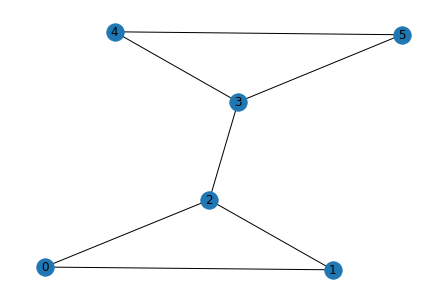

In [33]:
# create graph
A = np.array(
    [
        [0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 1, 0]
    ])

G = nx.from_numpy_matrix(A)

nx.draw(G, with_labels=True)


In [34]:
# clustering methods

def mod_max_clustering(G):

    # compute modularity matrix
    d = np.array([d_i for (i, d_i) in G.degree()])

    n_edges = len(G.edges)

    B = A - np.outer(d, d) / (2 * n_edges)

    # get leading e-vector
    w, v = np.linalg.eig(B)
    w_max_idx = np.argsort(w)[-1]
    v_max = v[:, w_max_idx]

    return v_max >= 0 # binary 

def spectral_clustering(G):

    # compute Laplacian
    d = np.array([d_i for (i, d_i) in G.degree()])
    D = np.diag(d)
    L = D - A

    # get second-smallest e-vector
    w, v = np.linalg.eig(L)
    w2_idx = np.argsort(w)[1]
    v2 = v[:, w2_idx]

    return v2 >= 0 # binary

def draw_clusters(G, cluster_func):
    clusters = ["blue" if x else "red" for x in cluster_func(G)]
    nx.draw(G, node_color=clusters, with_labels=True)

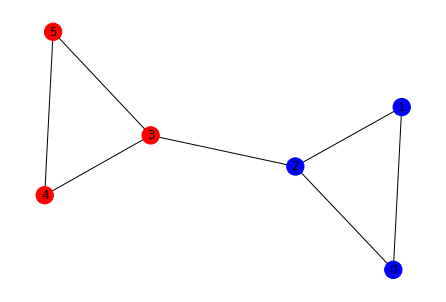

In [35]:
# Modularity maximization clustering
draw_clusters(G, mod_max_clustering)

These clusters make sense intuitively -- the 2-3 edge is a local bridge connecting the clusters

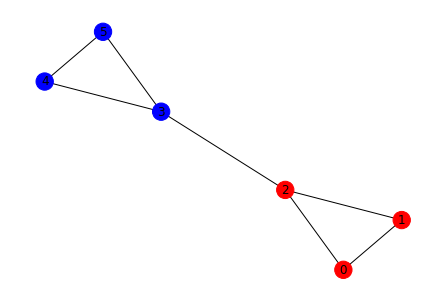

In [36]:
# Spectral clustering
draw_clusters(G, spectral_clustering)

Same clusters as above! the two methods agree here.

## b)

In [37]:
# A simple 2-component graph
A = np.array(
    [
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ]
)

G = nx.from_numpy_matrix(A)

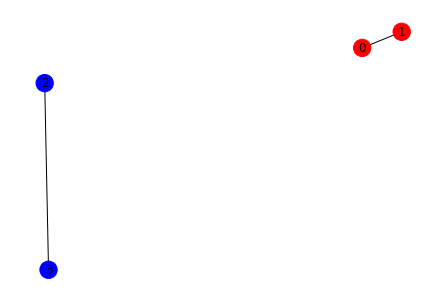

In [38]:
draw_clusters(G, mod_max_clustering)

Modularity maximization clustering gives the expected result: each component is its own cluster.


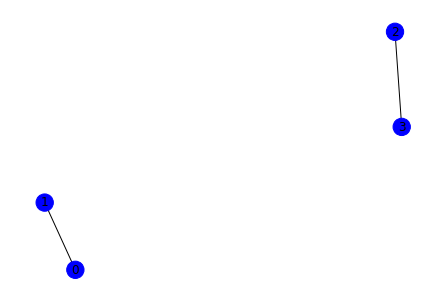

In [39]:
draw_clusters(G, spectral_clustering)

Spectral clustering has one component = V, and the other one empty (why is this the case?)


## 1.3.3: Hierarchical clustering and the chaining effect

## a)


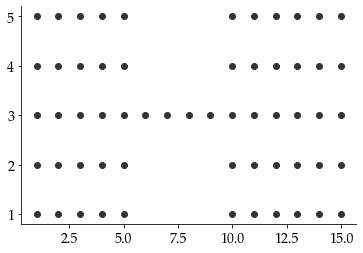

In [40]:
# Define the point cloud
grid_x = np.linspace(1, 15, num=15)
grid_y = np.linspace(1, 5, num=5)
grid_2d = np.array(list(product(grid_y, grid_x)))

allowed_region = (grid_2d[:, 1] <= 5) | (grid_2d[:, 1] >= 10) | (grid_2d[:, 0] == 3)

point_cloud = grid_2d[allowed_region, :]

plt.scatter(point_cloud[:, 1], point_cloud[:, 0])


In [41]:
def clust_dendrogram(X, linkage_metric):
    hier_clust = linkage(X, linkage_metric)
    fig = plt.figure(figsize=(15, 6))
    dn = dendrogram(hier_clust)
    plt.show()

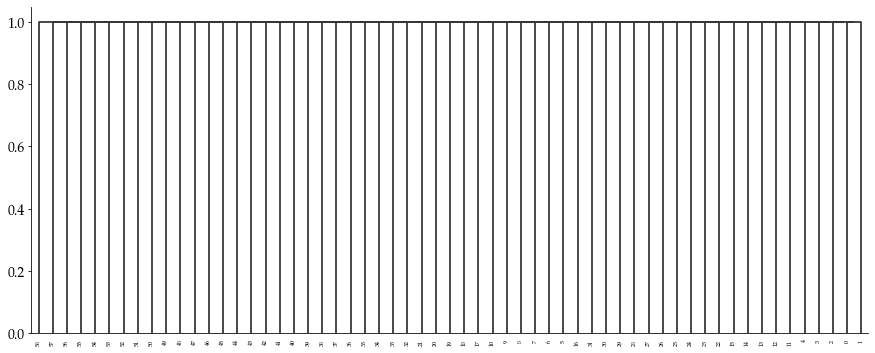

In [42]:
# Apply single-linkage hierarchical clustering to the point cloud
clust_dendrogram(point_cloud, 'single')

Single linkage causes individual points to be added to larger clusters one-by-one, instead of points being combined into clusters (which are then combined with other clusters). This is called the chaining effect, and produces degenerate trees such as the one above. Most other linkage metrics have the (more desirable) inherent property of considering clusters of several points as farther away than neighboring individual points, since some of these clusters' points are generally not immediate neighbors of "this" point.

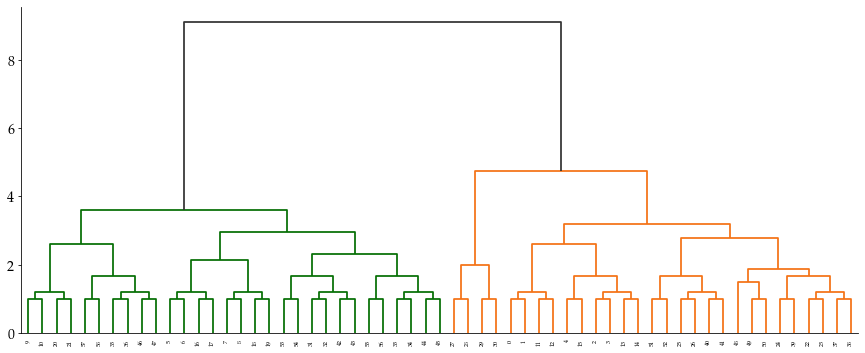

In [43]:
# Apply average-linkage hierarchical clustering to the point cloud
clust_dendrogram(point_cloud, 'average')

In this case, the two regions of points are clearly identified; the largest vertical distance in the dendrogram exists in the top-most level, meaning that 2 clusters is (as expected) the best choice for this data.

### b)

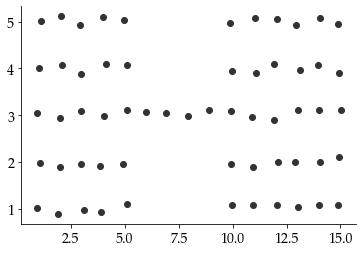

In [44]:
# Add uniform noise to the point cloud in the range [-0.125, 0.125) along both axes
point_cloud_perturbed = point_cloud + ((np.random.rand(*point_cloud.shape) - 0.5) / 4)

plt.scatter(point_cloud_perturbed[:, 1], point_cloud_perturbed[:, 0])

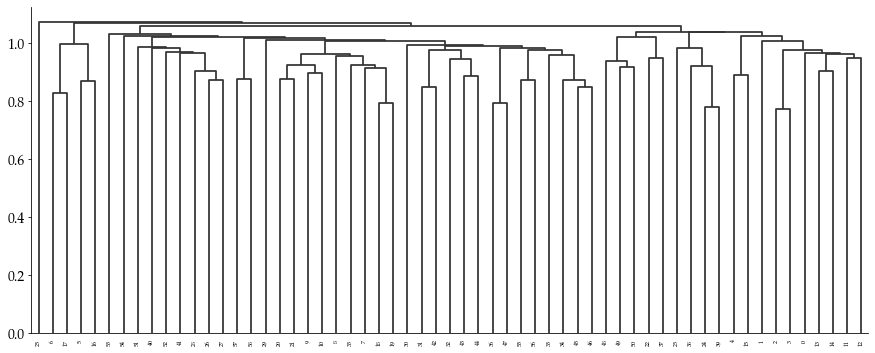

In [45]:
# Single linkage on the perturbed points
clust_dendrogram(point_cloud_perturbed, 'single')

Now that the points have been perturbed, the single linkage dengrogram much better resembles the expected tree structure. At the lowest level of the tree, it appears that each point is being combined with the neighbor it is farthest from after perturbation, and the "odd nodes out" (e.g. 52) are combined into clusters later. However, the largest vertical distance exists at the lowest level of the tree; that is, where pairs of neighboring points are combined into 2-point clusters. This implies that the best number of clusters is equal to the number of points; that is, each point should be in its own cluster. This is not a useful result at all, showing that even after perturbation, single-linkage hierarchical clustering is not useful for this problem.

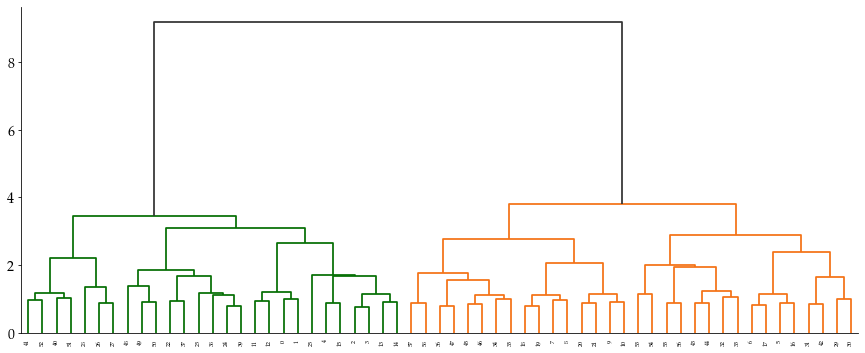

In [46]:
# Average linkage on the perturbed points
clust_dendrogram(point_cloud_perturbed, 'average')

The average linkage dendrogram looks almost exactly the same after the points are perturbed. From this example, average linkage appears to be much more robust than single linkage.

## Problem 4

## 1.4.1: Generating the graph

In [47]:
# create an empty undirected graph
G = nx.Graph()

# read in table
with open('primaryschool.csv') as f:
    reader = csv.reader(f, delimiter='\t')

    for row in reader:
        # interpret each data point
        t, i, j, c_i, c_j = row
        t, i, j = map(int, [t, i, j])

        if not G.has_node(i):
            G.add_node(i, c=c_i)

        if not G.has_node(j):
            G.add_node(j, c=c_j)
        
        # add the edge described by this row to the graph,
        #   or modify its weight if already present
        if G.has_edge(i, j):
            G[i][j]['weight'] += 1
        else:
            # weight = count of this pair's interactions
            G.add_edge(i, j, weight=1)

print('Nodes: {}; Edges: {}'.format(len(G.nodes), len(G.edges)))

Nodes: 242; Edges: 8317


## Problem 1.4.2: Descriptive analysis

In [48]:
# Generic function for plotting a distribution histogram
def analyze(data, name):
    plt.hist(data, bins=20)
    plt.title('{} distribution of school interactions graph'.format(name.capitalize()))
    plt.xlabel(name.capitalize())
    plt.ylabel('Frequency')
    print('Average {} of G: {}'.format(name, np.mean(data)))

Average degree of G: 68.73553719008264


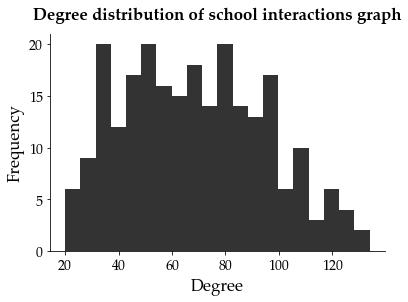

In [49]:
# Plot degree distribution
degrees = [G.degree(u) for u in G.nodes]
analyze(degrees, 'degree')

Average clustering coefficient of G: 0.5255415410620273


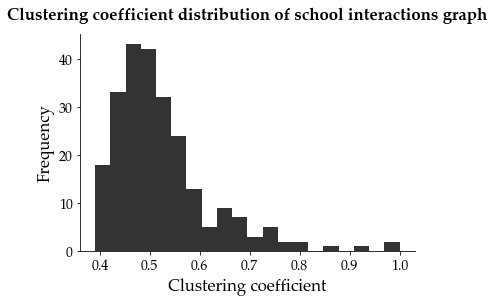

In [50]:
# Plot clustering coefficient distribution
clustering_coeffs = list(nx.algorithms.cluster.clustering(G).values())
analyze(clustering_coeffs, 'clustering coefficient')

Average betweenness centrality of G: 0.00305187865070928


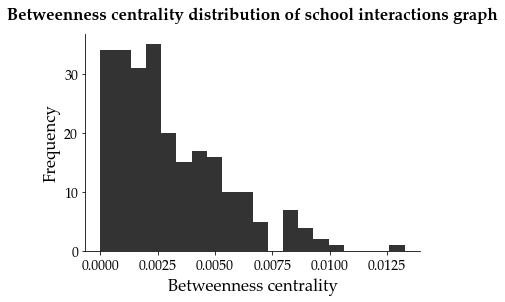

In [51]:
# Plot betweenness distribution
betweenness = list(nx.algorithms.centrality.betweenness_centrality(G).values())
analyze(betweenness, 'betweenness centrality')

## Problem 1.4.3: Plotting the graph

In [52]:
# Get the class of each node + class sizes
node_classes = [G.nodes[n]['c'] for n in G.nodes]
_, class_counts = np.unique(node_classes, return_counts=True)

# map classes to colors for drawing
colors = ['red', 'orange', 'green', 'blue', 'purple', 'pink', 'brown', 'cyan', 'gray', 'olive', 'skyblue']
class_id_map = {cl: i for i, cl in enumerate(set(node_classes))}

node_colors = [colors[class_id_map[c]] for c in node_classes]

# size nodes by degree
node_sizes = [G.degree(u) for u in G.nodes]

Color key:
1A: brown, 23 members
1B: pink, 25 members
2A: skyblue, 23 members
2B: purple, 26 members
3A: green, 23 members
3B: cyan, 22 members
4A: orange, 21 members
4B: red, 23 members
5A: gray, 22 members
5B: olive, 24 members
Teachers: blue, 10 members


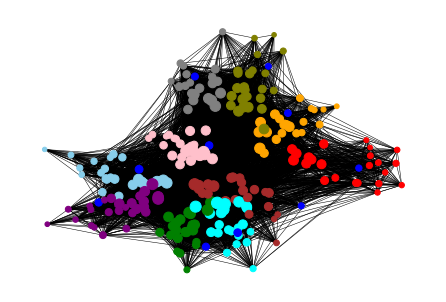

In [56]:
# Draw the graph
nx.draw(
    G, 
    pos=nx.spring_layout(G),
    node_size=node_sizes, 
    node_color=node_colors,
    width=0.5)

print('Color key:')
[print(cl + ': ' + colors[i] + ', {} members'.format(ct)) for (cl, i), ct in zip(sorted(class_id_map.items()), class_counts)];

Typically, larger nodes (i.e. those with higher degree) seem to be closer to the center of the graph, and closer to other nodes. This makes sense, since spring layout treats more central nodes as harder to "repel" from the center of the graph, and higher-degree nodes tend to be better-connected to others in the graph. Also, the nodes generally divide themselves into communities by color (i.e. class), and each class community contains one teacher (dark blue) node nearby. Also, some classes seem to interact with others more: the brown, light blue, and green classes are positioned close together and have many large nodes, meaning that they tend to interact more (maybe their classrooms are nearby), while the red class has many small, somewhat isolated nodes, making it appear as if they interact with others less (maybe they're in a temporary building or something). I'd predict that if I were to run a community detection algorithm on this graph with k=10, it would find 10 communities that are relatively class-homogeneous, with one teacher node per community.